In [1]:
! cd nb-based-workflow && pip install --editable .

Obtaining file:///Users/Edu/dev/projects-ploomber/nb-based-workflow
  Attempting uninstall: ploomber-nb
    Found existing installation: ploomber-nb 0.1.dev0
    Uninstalling ploomber-nb-0.1.dev0:
      Successfully uninstalled ploomber-nb-0.1.dev0
  Running setup.py develop for ploomber-nb


In [16]:
from pathlib import Path
from IPython.display import Image, HTML, Markdown, display
from ploomber_nb.pipeline import make

In [3]:
Markdown(filename='nb-based-workflow/README.md')

# Notebook-based workflow

This example project showcases the basic Ploomber experience, hopefully, this interactive tutorial will convince you to try out Ploomber in your next Data Science project.

Let's imagine you already build a simple Ploomber pipeline, which is organized in a few tasks. Ploomber allows you to quickly iterate by keeping track of source code changes and saving time to "build" your pipeline.



Let's first retrieve our pipeline:

In [4]:
dag = make()

Plotting it makes easy to understand dependencies between tasks, each note corresponds to one.

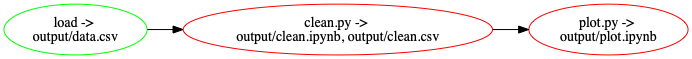

In [5]:
Image(filename=dag.plot())

Our pipeline has three tasks: load, clean and plot. Ploomber will keep track of your source code and mark as outdated any task that changed since last execution. Making your whole pipeline up-to-date is as simple as running:

In [9]:
dag.build()

name,Ran?,Elapsed (s),Percentage
load,False,0,0
clean.py,False,0,0
plot.py,False,0,0


Let's see what happens if we build again:

In [10]:
dag.build()

name,Ran?,Elapsed (s),Percentage
load,False,0,0
clean.py,False,0,0
plot.py,False,0,0


It didn't run anything! That's because our pipeline has not changed, there is nothing to run.

In [8]:
# helper function to display code
def display_code(code):
    display(Markdown("""
```python
{}
```
""".format(code)))

Our `dag` object is a fully interactive way of exploring our pipeline. Let's see where the code for each task comes from:

In [11]:
# get list of task names
list(dag)

['load', 'clean.py', 'plot.py']

In [13]:
# get task
task = dag['load']

# print source code
print(task.source)

# where is this code declared?
print(task.source.loc)

def load(product):
    df = pd.DataFrame({'x': np.random.rand(500)})
    df['x'] = df['x'] + 1
    df.to_csv(str(product), index=False)

/Users/Edu/dev/projects-ploomber/nb-based-workflow/src/ploomber_nb/functions.py:5


Go ahead and modify the function, for example, instead of having:

```python
df['x'] = df['x'] = 1
```

Replace it with:

```python
df['x'] = df['x'] = 2
```

Then come back and run:

In [ ]:
dag.build()

You should see that all three tasks ran again, that's because the load function is the root node. Let's try with another one:

In [15]:
print(dag['clean.py'].source.loc)

/Users/Edu/dev/projects-ploomber/nb-based-workflow/src/ploomber_nb/notebooks/clean.py


Go ahead and modify the file, then run:

In [ ]:
dag.build()

You should see that Ploomber skipped running the load task since modify clean does not affected it. Imagine if the loading task download a huge dataset, you could save a lot of time by letting Ploomber automatically figure out which tasks to run.

Let's take a look at the actual pipeline declaration, where we'll find a bunch of intersting things.

In [19]:
Markdown("""
```python
{}
```
""".format(Path('nb-based-workflow/src/ploomber_nb/pipeline.py').read_text()))


```python
from pathlib import Path

from ploomber_nb import functions

from ploomber import DAGConfigurator, SourceLoader
from ploomber.tasks import NotebookRunner, PythonCallable
from ploomber.products import File


def make():
    cfg = DAGConfigurator()
    cfg.params.hot_reload = True
    dag = cfg.create()

    # we will save all output here
    out = Path('output')
    out.mkdir(exist_ok=True)

    # source loaders allows us to easily load files from modules
    loader = SourceLoader(path='notebooks', module='ploomber_nb')

    # out first task is a Python function, it generates and output csv file
    load = PythonCallable(functions.load,
                          product=File(out / 'data.csv'),
                          dag=dag,
                          name='load')

    # Our second task is a Python script, why is it using a task called
    # NotebookRunner? This task runs code as a Jupyter notebook, you might
    # pass a .ipynb but you can pass .py files as well, which will be converted
    # to notebooks before execution. It is hard to run git diff .ipynb files
    # (they are JSON strings), using scripts allows you to easily control
    # versions
    clean = NotebookRunner(loader['clean.py'],
                           # this task generates two files, the .ipynb
                           # output notebook itself and another csv file
                           product={'nb': File(out / 'clean.ipynb'),
                                    'data': File(out / 'clean.csv')},
                           dag=dag,
                           # you can run any language supported by Jupyter
                           # by specifying which kernel to use
                           kernelspec_name='python3',
                           # by enabling this option, a few checks are
                           # performed on your code before running the
                           # notebook, given that jupyter notebooks are run
                           # cell by cell, something as simple as a syntax
                           # error will be discovered until such cell is run
                           # this gives you immediate feedback
                           static_analysis=True,
                           papermill_params={'nest_asyncio': True})

    # the final task is also a notebook that generates a plot
    plot = NotebookRunner(loader['plot.py'],
                          File(out / 'plot.ipynb'),
                          dag=dag,
                          kernelspec_name='python3',
                          static_analysis=True,
                          papermill_params={'nest_asyncio': True})

    # declare execution dependencies, by leveraging the graph structure
    # Ploomber can even run tasks in parallel
    load >> clean >> plot

    return dag

```


You've made it to the end of this tutorial. Hopefully this will convince you to give Ploomber a try. Don't hesitate with any questions you might have. Feel free to [open an issue](https://github.com/ploomber/ploomber/issues/new) in the repository. Thanks for reading!